In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

# Note to self about optimising:
 - Get values of development time at observation days;
 - Then scale GDD function so that development time is 1 at these days;
 - Use these as observations to optimise.

In [2]:
def RMSE_ML_model2(ds, phases, training_means):
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    for phase_index, phase in enumerate(phases):
        print('Phase: ' + str(phase))
        ML_residuals = ds[f'ML prediction emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        ML_residuals = ML_residuals.where(np.abs(ML_residuals) < 60)
        model_residuals = ds[f'modelled time emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        model_residuals = model_residuals.where(np.abs(model_residuals) < 60)
        residuals_to_average = training_means[phase_index] - ds[f'observed time emergence to {phase}']
        residuals_to_average = residuals_to_average.where(np.abs(model_residuals) < 60)
        print('RMSE for ML is ' + str(np.round(RMSE(ML_residuals), decimals=1)))
        print('RMSE for model is ' + str(np.round(RMSE(model_residuals), decimals=1)))
        print('RMSE to training mean is ' + str(np.round(RMSE(residuals_to_average), decimals=1)))

In [3]:
def RMSE_model2(ds, phases):
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    RMSEs = []
    for phase_index, phase in enumerate(phases):
        #print('Phase: ' + str(phase))
        model_residuals = ds[f'modelled time to {phase}'] - ds[f'observed time to {phase}']
        model_residuals = model_residuals.where(np.abs(model_residuals) < 60)
        #print('RMSE for model is ' + str(np.round(RMSE(model_residuals), decimals=1)))
        RMSEs.append(RMSE(model_residuals))
    return RMSEs

In [4]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    
    def __init__(self, address, raw = False):
        if raw:
            self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        else:
            self.phen_data = pd.read_csv(address)
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        self.phase_list = [] #list of phases to consider
        self.add_locations()
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            try:
                self.phen_data = self.phen_data.drop(drop_name, axis = 1)
            except:
                print(f'Column {drop_name} not found')
                continue
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def align_emergence_obs_with_driver_data(self):
        ## Make sure we are comparing to observations where we have the driver data;
        #1. Align the times - need to check as it might run for some days then go off the end.
        self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2024)
        ## Make sure all elements are in the driver data
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Eintrittsdatum'] + np.timedelta64(12, 'h'), self.GDD_driver_data['time'])]
        self.just_emergence = self.just_emergence.loc[np.isin(self.just_emergence['Stations_id'], self.GDD_driver_data['Stations_id'])]
        self.just_emergence = self.just_emergence.dropna()
    
    def get_unique_xy_station(self, x_coords, y_coords, station_ids):
        unique_values = np.unique(np.stack([x_coords, y_coords, station_ids]), axis = 1)
        return unique_values[0, :], unique_values[1, :], unique_values[2, :]

    def make_input_array(self, epsg_num = 3035):
        ## Puts pandas phenological frame into driver xarray and aligns the two
        self.just_emergence = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        self.just_emergence = self.just_emergence.where(self.just_emergence['Eintrittsdatum'] > np.datetime64('2017-01-01')).dropna()
        x_coords = self.just_emergence['lon'].values
        y_coords = self.just_emergence['lat'].values
        station_ids = np.int64(self.just_emergence['Stations_id'].values)
        x_unique, y_unique, stations = self.get_unique_xy_station(x_coords, y_coords, station_ids)
        #Makes an array to put into GDD model
        print('project to new coords')
        x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_unique, y_unique, epsg_num = epsg_num)
        print('interpolate driver to station locations')
        self.x_epsg = x_epsg
        self.y_epsg = y_epsg
        # Working in xarray (not pandas) after this point:
        self.GDD_driver_data = dataset_fctns.interpolate_xy(x_epsg, y_epsg, self.T_mean)
        self.GDD_driver_data = self.GDD_driver_data.assign_coords(Stations_id=("modelpoint", stations))
        self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
        self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])

    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        #self.just_emergence = self.just_emergence.where(self.just_emergence['Referenzjahr'] <= 2019)
        ## Make the indexer to extract things at the right time.
        #self.align_emergence_obs_with_driver_data()
        self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
        self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'WC SOS date']])
        time_station = time_station.rename({'index':'Emergence observation', 'WC SOS date':'time'})
        time_station['time'] += np.timedelta64(12, 'h')
        ## Initiate development time storage object.
        t_dev = np.zeros(time_station.sizes['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        ## Make sure driver dataset uses station id to index this dimension
        try:
            self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Stations_id'])
        except:
            print('Couldn\'t reset index for station')
        #Run model
        for day in range(300):
            #print(day)
            driver_values = self.GDD_driver_data.sel(time_station)[driver_variable].values 
            t_dev += response(driver_values, t_dev)
            dev_time_series.append(t_dev.copy())
            time_station['time'] += np.timedelta64(1, 'D')
        dev_time_series.append(self.just_emergence['Eintrittsdatum'].values.astype('datetime64[Y]'))
        dev_time_series.append(self.just_emergence['Stations_id'].values)
        self.model_dev_time_series = np.array(dev_time_series)
        self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        column_names = np.concatenate([np.array(thresholds), ['Referenzjahr'], ['Stations_id']])
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:-2, obs_index].astype(np.float64))
        self.phase_dates_array = np.concatenate([self.phase_dates_array, [pd.to_datetime(self.model_dev_time_series[-2]).year], [self.model_dev_time_series[-1]]], axis=0)
        self.phase_dates_array = pd.DataFrame(self.phase_dates_array.T, columns = column_names)
        self.phase_dates_array.set_index(['Referenzjahr', 'Stations_id'])
        self.phase_dates_calculated = True
        
        #Note that the thresholds are NOT the bins for numpy digitize!
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, winter_sowing = False):
        observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', self.phase_list[0], winter_sowing=winter_sowing).dropna()
        self.ds_observed = pd.DataFrame({f'observed time to {self.phase_list[0]}': observed_to_first_stage})
        for phase in self.phase_list[1:]:
            self.ds_observed[f'observed time to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
        self.ds_observed = self.ds_observed.reset_index()
        self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        self.ds_observed = self.ds_observed.merge(self.just_emergence[['Eintrittsdatum', 'Referenzjahr', 'Stations_id']], how = 'outer', on=['Referenzjahr', 'Stations_id']).rename(columns={'Eintrittsdatum':'emergence date'})
        #self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #self.ds_observed = pd.concat([self.just_emergence.set_index(['Referenzjahr', 'Stations_id'], inplace=False)['Eintrittsdatum'], self.ds_observed], axis=1).rename(columns={'Eintrittsdatum':'emergence date'})
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.merge(self.ds_observed, self.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])

    def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
        self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
        self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
        self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
        self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
        time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
        time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
        time_station = time_station.drop_vars('index')
        time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
        time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
        time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] + pd.Timedelta(12, 'h')
        time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
        time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
        self.time_station = time_station
        self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
        self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
        self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
        self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
        self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
        self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML['tas'].unstack(),
                                            self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                            self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                            self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
        self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
        self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML.reset_index(), self.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
        if self.phase_dates_calculated:
            self.driver_frame_for_ML = pd.merge(self.driver_frame_for_ML, self.phase_dates_array.reset_index(), how='left', on=['Referenzjahr', 'Stations_id'])

    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md, min_samples_leaf=5)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(self.phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_9808\1100107346.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [3]:
address1 = "C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_akt.txt"
address2 = "C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt"
pd1 = pd.read_csv(address1, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
pd2 = pd.read_csv(address2, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
pd3 = pd.concat([pd1, pd2], axis = 0)
pd3 = pd3.drop('Unnamed: 9', axis = 1)
pd3.drop_duplicates(inplace=True)
pd3.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv')
address3 = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv'
pd4 = pd.read_csv(address3)

In [5]:
#Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt", raw = True)
Maize_set = Phenology_set('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\maize_phenology_20250224.csv', raw = False)
Maize_set.drop_columns(['Unnamed: 9', 'Unnamed: 0'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\hyras_meantemp_2017_2025.nc') #C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array()
Maize_set.phase_list = ['beginning of flowering', 'yellow ripeness']


Column Unnamed: 9 not found
project to new coords
interpolate driver to station locations


In [134]:
tp=3
#0.07, 0.04
#coeff_1 = 0.03
#coeff_2 = 0.025
#coeff_1 = 1
#coeff_2 = 1
#coeff_3 = 1
coeff_1 = 0.7867573678269909 
coeff_2 = 0.037684642877912046 
coeff_3 = 0.049761431878384825
#coeff_1 = 2.7456293565248133/100#0.5920545713820773/10#
#coeff_2 = 0.03769911854395983 
#coeff_3 = 0.04976143187838482
### changed min temp for maize to 4 just to test (was 8 before)
#resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 2, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_3*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
#thresholds = [0.2, 1, 2]
#thresholds = [0.01, 1.01, 2.01]
thresholds = [1, 2, 3]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.get_observed_dataset()
Maize_set.get_X_y_for_ML(driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2017, end_year = 2024)


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 105. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


Couldn't reset index for station




C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_9808\1100107346.py:188: UserWarning: rename 'index' to 'Stations_id' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})


In [126]:
dev_time_frame = pd.DataFrame(Maize_set.model_dev_time_series.T, columns=[f't_dev at day {n}' for n in range(301)] + ['Referenzjahr', 'Stations_id'])
dev_time_frame['Referenzjahr'] = pd.to_datetime(dev_time_frame['Referenzjahr']).dt.year
obs_ds = Maize_set.ds_observed.dropna(subset=['emergence date'])
ds_optimising = pd.merge(dev_time_frame, obs_ds, how='left', on=['Referenzjahr', 'Stations_id'])
ds_optimising = ds_optimising.merge(Maize_set.just_emergence[['Stations_id', 'Referenzjahr', 'WC SOS date']], how='outer', on=['Referenzjahr', 'Stations_id'])
ds_optimising = ds_optimising.dropna()

In [127]:
ds_optimising = ds_optimising.where(ds_optimising['emergence date'] > ds_optimising['WC SOS date']).dropna()
ds_optimising = ds_optimising.where(ds_optimising['observed time to beginning of flowering'] >0).dropna()
ds_optimising = ds_optimising.where(ds_optimising['observed time to yellow ripeness'] >0).dropna()
ds_optimising['emergence index'] = (ds_optimising['emergence date'] - ds_optimising['WC SOS date']).dt.days.astype('int64')
ds_optimising['flowering index'] = (ds_optimising['observed time to beginning of flowering'] + ds_optimising['emergence index']).astype('int64')
ds_optimising['yellow ripeness index'] = (ds_optimising['observed time to yellow ripeness'] + ds_optimising['emergence index']).astype('int64')


In [128]:
ds_optimising['dev time at observed emergence'] = [ds_optimising.loc[i, f't_dev at day {ds_optimising.loc[i, "emergence index"]}'] for i in ds_optimising.index]
ds_optimising['dev time at observed flowering'] = [ds_optimising.loc[i, f't_dev at day {ds_optimising.loc[i, "flowering index"]}'] for i in ds_optimising.index]
ds_optimising['dev time at observed ripeness'] = [ds_optimising.loc[i, f't_dev at day {ds_optimising.loc[i, "yellow ripeness index"]}'] for i in ds_optimising.index]#
#ds_optimising['flowering index'] = (ds_optimising['observed time to beginning of flowering'] + ds_optimising['emergence index']).astype('int64')
#ds_optimising['yellow ripeness index'] = (ds_optimising['observed time to yellow ripeness'] + ds_optimising['emergence index']).astype('int64')

In [129]:
ds_optimising['coeff for emergence'] = 1/ds_optimising['dev time at observed emergence']
ds_optimising['coeff for flowering'] = 1/(ds_optimising['dev time at observed flowering'] - ds_optimising['dev time at observed emergence'])
ds_optimising['coeff for ripeness'] = 1/(ds_optimising['dev time at observed ripeness'] - ds_optimising['dev time at observed flowering'])

In [87]:
#ds_optimising.where(ds_optimising['coeff for emergence'].isin([np.inf, -np.inf])).dropna()

(array([2.347e+03, 2.020e+02, 1.800e+01, 7.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00]),
 array([0.08697102, 0.82260494, 1.55823885, 2.29387277, 3.02950669,
        3.76514061, 4.50077453, 5.23640844, 5.97204236, 6.70767628,
        7.4433102 ]),
 <BarContainer object of 10 artists>)

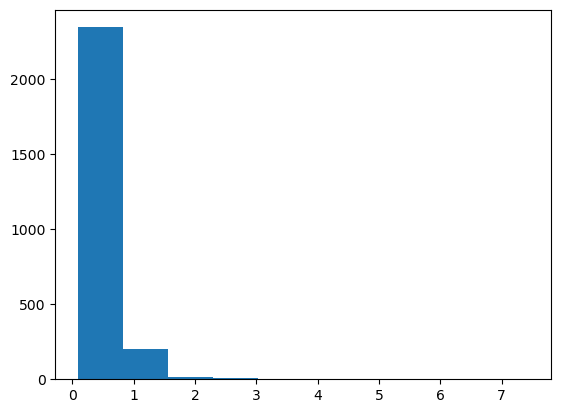

In [130]:
plt.hist(ds_optimising.where((~ds_optimising['coeff for emergence'].isin([np.inf, -np.inf]))*(ds_optimising['coeff for emergence']<10))['coeff for emergence'])#, bins = 20)#[[f't_dev at day {n}' for n in range(200, 300)]]

In [133]:
print(ds_optimising['coeff for emergence'].where(~ds_optimising['coeff for emergence'].isin([np.inf, -np.inf])).dropna().mean(),
      ds_optimising['coeff for flowering'].where(~ds_optimising['coeff for flowering'].isin([np.inf, -np.inf])).dropna().mean(),
      ds_optimising['coeff for ripeness'].where(~ds_optimising['coeff for ripeness'].isin([np.inf, -np.inf])).dropna().mean())

0.7867573678269909 0.037684642877912046 0.049761431878384825


In [78]:
phase_list2 = ['emergence', 'beginning of flowering', 'yellow ripeness']
thresholds = [0.1, 1, 2]
RMSE_list = []
coord_list = []
Maize_set.get_observed_dataset()
for coeff_1 in np.arange(0.02, 0.09, 0.005):
    for coeff_2 in np.arange(0.02, 0.09, 0.005):
        print([coeff_1, coeff_2])
        resps = [lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_1*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: coeff_2*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
        #[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
        Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                                    'tas', thresholds[-1])
        Maize_set.get_phase_dates(thresholds)
        for index, phase in enumerate(phase_list2):
            Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(np.float64(thresholds[index])):f'modelled time to {phase}'})
        Maize_set.phase_dates_array = Maize_set.phase_dates_array.where(Maize_set.phase_dates_array['modelled time to yellow ripeness'] < 200)
        Maize_set.phase_dates_array['modelled time to beginning of flowering'] = Maize_set.phase_dates_array['modelled time to beginning of flowering'] - Maize_set.phase_dates_array['modelled time to emergence']
        Maize_set.phase_dates_array['modelled time to yellow ripeness'] = Maize_set.phase_dates_array['modelled time to yellow ripeness'] - Maize_set.phase_dates_array['modelled time to beginning of flowering']
        ds_comparison = pd.merge(Maize_set.ds_observed, Maize_set.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])
        ds_comparison = ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon'])
        ds_comparison = dataset_fctns.add_SOS_to_df(ds_comparison)
        ds_comparison['observed time to emergence'] = pd.to_datetime(ds_comparison['emergence date']).dt.dayofyear - ds_comparison['SOS']
        RMSE_list.append(RMSE_model2(ds_comparison, phase_list2))
        coord_list.append([coeff_1, coeff_2])



[0.02, 0.02]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 105. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.025]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.030000000000000002]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.035]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.04000000000000001]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


[0.02, 0.045000000000000005]
Couldn't reset index for station


c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


KeyboardInterrupt: 

In [ ]:
phase_dates_array
        ds_comparison = pd.merge(Maize_set.ds_observed, Maize_set.phase_dates_array, how='outer', on=['Referenzjahr', 'Stations_id'])
        ds_comparison = ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon'])
        ds_comparison = dataset_fctns.add_SOS_to_df(ds_comparison)
        ds_comparison['observed time to emergence'] = pd.to_datetime(ds_comparison['emergence date']).dt.dayofyear - ds_comparison['SOS']
        RMSE_list.append(RMSE_model2(ds_comparison, phase_list2))
        coord_list.append([coeff_1, coeff_2])

In [22]:
print(coord_list[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()],
      RMSE_list[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()])

[0.02, 0.02] [nan, nan, nan]


In [23]:
RMSE_list#[np.linalg.norm(np.array(RMSE_list), axis = 1).argmin()]

[[nan, nan, nan],
 [7.220660013771785, 15.393684329665179, 22.578517969171727],
 [8.791872934874018, 16.616525235171434, 29.05142866102073],
 [9.572624255403277, 17.764039123263906, 31.080074235637753],
 [11.187302521381909, 18.282936127019028, 32.09855081285936],
 [12.233118419143224, 18.813491535813228, 34.64408702733335],
 [12.774953394401766, 18.90333754162915, 36.2741655335881],
 [12.883372483542793, 19.395404393982, 37.906292739975285],
 [13.161561185365278, 20.191577529990226, 38.4126778660503],
 [13.817727792842145, 20.463755914358657, 39.08831733042672],
 [14.161385272166976, 20.722957676613575, 39.66489496034962],
 [14.518529049974275, 20.8833810202486, 40.931196772123734],
 [14.745794533374333, 21.128953279011874, 41.75056035094004],
 [15.067820535375198, 21.209035666817805, 42.87106138028109],
 [6.635761699558938, 9.311283477587825, 19.616051429485257],
 [8.180915248410534, 11.43029681999809, 25.134421227368307],
 [10.056459759381381, 12.562090687818632, 27.82148307755934],

In [25]:
ds_comparison#.dropna(subset = ['modelled time to beginning of flowering'])

,Referenzjahr,Stations_id,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,lat,lon,emergence date,modelled time to emergence,modelled time to beginning of flowering,modelled time to yellow ripeness
0,1951.0,7617.0,29.0,NaN,54.6167,9.0333,NaT,NaN,NaN,NaN
1,1951.0,7899.0,80.0,NaN,52.0833,9.5667,NaT,NaN,NaN,NaN
2,1951.0,8137.0,50.0,NaN,52.8667,9.6000,NaT,NaN,NaN,NaN
3,1951.0,8191.0,54.0,NaN,53.2667,10.1167,NaT,NaN,NaN,NaN
4,1951.0,8234.0,98.0,NaN,52.9333,11.1167,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
28902,2023.0,19612.0,84.0,121.0,52.0507,10.6362,2023-05-18,38.0,76.0,114.0
28903,2023.0,19700.0,78.0,132.0,50.4316,11.9443,2023-05-19,49.0,85.0,128.0
28904,2023.0,19722.0,55.0,109.0,47.8655,9.0147,2023-05-21,38.0,71.0,107.0
28905,2023.0,19770.0,NaN,NaN,NaN,NaN,2023-05-20,36.0,74.0,113.0


In [24]:
dataset_fctns.add_SOS_to_df(ds_comparison.dropna(subset = ['modelled time to beginning of flowering', 'lat', 'lon']))

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SOS'] = WC_SOS(df['lon'], df['lat'])


,Referenzjahr,Stations_id,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,lat,lon,emergence date,modelled time to emergence,modelled time to beginning of flowering,modelled time to yellow ripeness,SOS
24456,2017.0,7532.0,80.0,134.0,54.4000,8.7667,2017-05-14,45.0,98.0,162.0,103.0
24457,2017.0,7564.0,80.0,128.0,54.7167,9.9500,2017-05-10,44.0,101.0,183.0,104.0
24458,2017.0,7564.0,80.0,128.0,54.7167,9.9500,2017-05-10,35.0,81.0,113.0,104.0
24459,2017.0,7592.0,76.0,NaN,53.4833,10.6333,2017-05-19,40.0,84.0,135.0,104.0
24461,2017.0,7616.0,76.0,139.0,54.6167,8.9667,2017-05-14,46.0,103.0,187.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...
28900,2023.0,19587.0,49.0,123.0,48.7091,9.2147,2023-05-27,36.0,67.0,94.0,106.0
28902,2023.0,19612.0,84.0,121.0,52.0507,10.6362,2023-05-18,38.0,76.0,114.0,105.0
28903,2023.0,19700.0,78.0,132.0,50.4316,11.9443,2023-05-19,49.0,85.0,128.0,107.0
28904,2023.0,19722.0,55.0,109.0,47.8655,9.0147,2023-05-21,38.0,71.0,107.0,109.0


In [55]:
Maize_set.phase_dates_array

,1,2,3,Referenzjahr,Stations_id
0,26.0,29.0,115.0,2022,7521.0
1,24.0,26.0,108.0,2023,7521.0
2,26.0,28.0,114.0,2022,7532.0
3,18.0,26.0,88.0,2023,7532.0
4,23.0,26.0,65.0,2022,7592.0
...,...,...,...,...,...
4443,6.0,9.0,104.0,2019,19727.0
4444,20.0,22.0,77.0,2017,19731.0
4445,26.0,28.0,64.0,2017,19914.0
4446,3.0,4.0,23.0,2018,19914.0


In [137]:
phase_list2 = ['emergence', 'beginning of flowering', 'yellow ripeness']
for index, phase in enumerate(phase_list2):
    print(phase)
    print(str(np.float64(thresholds[index])))
    #Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(np.float64(thresholds[index])):f'modelled time to {phase}'})
    Maize_set.phase_dates_array = Maize_set.phase_dates_array.rename(columns={str(thresholds[index]):f'modelled time to {phase}'})
Maize_set.phase_dates_array['modelled time to beginning of flowering'] = Maize_set.phase_dates_array['modelled time to beginning of flowering'] - Maize_set.phase_dates_array['modelled time to emergence']
Maize_set.phase_dates_array['modelled time to yellow ripeness'] = Maize_set.phase_dates_array['modelled time to yellow ripeness'] - Maize_set.phase_dates_array['modelled time to emergence']
        

emergence
1.0
beginning of flowering
2.0
yellow ripeness
3.0


In [138]:
ds = Maize_set.driver_frame_for_ML['modelled time to emergence'] + pd.to_datetime(Maize_set.driver_frame_for_ML['WC SOS']).dt.dayofyear
ds = ds.where(ds < 200)
plt.hist(ds.dropna(), bins = 20)

KeyError: 'modelled time to emergence'

In [139]:
Maize_set.get_X_y_for_ML(start_year = 2017, end_year = 2024)

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dataset_fctns.py:107: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104. 104. 103. ... 105. 105. 105.]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, 'SOS'] = WC_SOS(df['lon'], df['lat'])
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_9808\1100107346.py:188: UserWarning: rename 'index' to 'Stations_id' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})


In [140]:
Maize_set.driver_frame_for_ML.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')

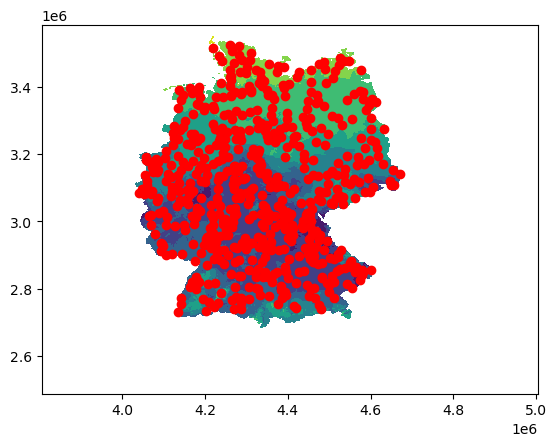

In [11]:
fig, axs = plt.subplots()
axs.contourf(Maize_set.T_mean['x'], Maize_set.T_mean['y'], Maize_set.T_mean['tas'].isel(time = 0).values)
for index, x in enumerate(Maize_set.x_epsg):
    axs.plot(x, Maize_set.y_epsg[index], 'ro')

In [104]:
## Functions for ML ##    
def put_obs_data_in_input_array(self): #, predictor_days = 200
    y_data = {}
    for phase_time in self.ds_observed.columns:
        if phase_time != 'lat' and phase_time != 'lon':
            y_data[phase_time] = (['modelpoint'], self.ds_observed[phase_time].values)
    #print(y_data)
    obs_data = xr.Dataset(data_vars = y_data,
                            coords = {'Referenzjahr':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(0))),
                                    'Stations_id':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(1)))}
                                    )
    #print(obs_data)
    obs_data = obs_data.set_xindex(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = self.GDD_driver_data.reset_index('modelpoint')
    #self.GDD_driver_data['Stations_id'] = self.GDD_driver_data['Stations_id'].astype(np.int64)
    #self.GDD_driver_data['Referenzjahr'] = self.GDD_driver_data['Referenzjahr'].astype(np.int64)
    self.GDD_driver_data = self.GDD_driver_data.set_coords(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_coords(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_xindex(['Referenzjahr', 'Stations_id'])
    self.GDD_driver_data = xr.merge([self.GDD_driver_data, obs_data], join='left') #self.data_for_ML = xr.merge([self.data_for_ML, obs_data], join='left')#[driver_variable]
    self.GDD_driver_data = self.GDD_driver_data.dropna('modelpoint') #self.data_for_ML = self.data_for_ML.dropna('modelpoint')


In [89]:
def get_X_y_for_ML(self, driver_variable = 'tas', predictor_days = 200, cumulative = False, thinning_parameter = 1, start_year = 2020, end_year = 2023):
    self.just_emergence = dataset_fctns.add_EOS_to_df(self.just_emergence)
    self.just_emergence = dataset_fctns.add_SOS_to_df(self.just_emergence)
    self.just_emergence['WC SOS date'] = pd.to_datetime(self.just_emergence['Referenzjahr'], format='%Y') + pd.to_timedelta(self.just_emergence['SOS'], 'D')
    self.just_emergence['SOS'] = pd.to_timedelta(self.just_emergence['SOS'], 'D')
    time_station = xr.Dataset.from_dataframe(self.just_emergence[['Stations_id', 'SOS']].drop_duplicates()) #, 'Referenzjahr'
    time_station = time_station.set_coords('Stations_id').set_xindex(['Stations_id'])
    time_station = time_station.drop_vars('index')
    time_station = time_station.expand_dims(dim={'time':pd.to_timedelta(np.arange(0, predictor_days), 'D')})
    time_station = time_station.expand_dims(dim={'Referenzjahr':pd.date_range(f'{start_year}-01-01', periods = end_year - start_year, freq='YS')})
    time_station['SOS'] = time_station['SOS'] + time_station['Referenzjahr'] + time_station['time'] + pd.Timedelta(12, 'h')
    time_station = time_station.rename({'time':'time_from_SOS', 'SOS':'time'})
    time_station = time_station.reset_index('Stations_id').reset_coords(names = 'Stations_id')
    self.time_station = time_station
    self.driver_data_for_ML = self.GDD_driver_data[driver_variable].sel(time_station)
    self.driver_data_for_ML = self.driver_data_for_ML.rename({'index': 'Stations_id'})
    self.driver_data_for_ML = self.driver_data_for_ML.set_xindex(['Stations_id'])
    self.driver_data_for_ML['Referenzjahr'] = pd.to_datetime(self.driver_data_for_ML['Referenzjahr']).year
    self.driver_frame_for_ML = self.driver_data_for_ML.to_dataframe(dim_order = ['Referenzjahr', 'Stations_id', 'time_from_SOS'])
    self.driver_frame_for_ML = pd.concat([self.driver_frame_for_ML['tas'].unstack(),
                                          self.driver_frame_for_ML['lat'].unstack()['0 days'].rename('lat'),
                                          self.driver_frame_for_ML['lon'].unstack()['0 days'].rename('lon'),
                                          self.driver_frame_for_ML['time'].unstack()['0 days'].rename('WC SOS')], axis=1)
    self.driver_frame_for_ML.rename(columns={self.driver_frame_for_ML.columns[x]: f'{driver_variable} day {x}' for x in range(200)}, inplace=True)
    self.driver_frame_for_ML = pd.merge(hmm.driver_frame_for_ML.reset_index(), hmm.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)
    #self.X_for_ML = self.driver_data_for_ML[:predictor_days, :].values.T
    #if cumulative:
    #    self.X_for_ML = np.cumsum(self.X_for_ML, axis=1)
    #if thinning_parameter != 1:
    #    self.X_for_ML = self.X_for_ML[:, ::thinning_parameter]
    #self.y_for_ML = np.array([self.GDD_driver_data[phase_time].values for phase_time in self.ds_observed.columns[:-2]])[:predictor_days, :].T
    #for station in self.just_emergence['Stations_id'].unique():
    #    just_station = self.just_emergence.where(self.just_emergence['Stations_id'] == station).dropna()
    #    for year in just_station['Referenzjahr'].unique():
    #        just_station_year = just_station.where(just_station['Referenzjahr'] == year).dropna()
    #        print(just_station_year)
    #        station_data = self.GDD_driver_data.sel({'Stations_id':station})
    #        #, time = slice(just_station_year['WC SOS date'].values[0] + pd.Timedelta(12, 'h'), just_station_year['WC SOS date'].values[0] + pd.Timedelta(12, 'h') + pd.Timedelta(predictor_days, 'D')))
    #        print(station_data)
    return self

In [ ]:
hmm = get_X_y_for_ML(Maize_set, start_year = 2022, end_year=2025)

In [ ]:
pd.merge(hmm.driver_frame_for_ML.reset_index(), hmm.ds_observed, how='left', on=['Referenzjahr', 'Stations_id'], suffixes=(None, '_observed')).drop(['lat_observed', 'lon_observed'], axis = 1)

In [ ]:
pd.concat([hmm.driver_frame_for_ML, hmm.ds_observed.set_index(['Referenzjahr', 'Stations_id'])], axis=1, )
hmm.driver_frame_for_ML.join(hmm.ds_observed.set_index(['Referenzjahr', 'Stations_id']), how='left')

In [ ]:
hmm.driver_frame_for_ML.index.get_level_values(0) = hmm.driver_frame_for_ML.index.get_level_values(0).year#['Referenzjahr']

In [73]:
obs = xr.Dataset.from_dataframe(hmm.ds_observed)
obs = obs.reset_index('index')
obs = obs.assign_coords({'Stations_id':obs['Stations_id'],'Referenzjahr':obs['Referenzjahr']})
obs = obs.set_xindex(['Stations_id', 'Referenzjahr'])

In [5]:
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)


<xarray.Dataset> Size: 14kB
Dimensions:                (Emergence observation: 600)
Coordinates:
  * Emergence observation  (Emergence observation) int64 5kB 448 983 ... 411726
Data variables:
    Stations_id            (Emergence observation) float64 5kB 7.521e+03 ... ...
    time                   (Emergence observation) datetime64[ns] 5kB 2022-05...


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_7620\3188619908.py:113: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  t_dev = np.zeros(time_station.dims['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.


ValueError: those coordinates already have an index: {'Stations_id'}

In [ ]:
Maize_set.compare_modelled_observed()

In [36]:
observed_dataset.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\observed_times.csv')

In [2]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array()
tp=3
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
thresholds = [1, 2]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.phase_list = ['beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.get_modelled_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.put_obs_data_in_input_array()
Maize_set.compare_modelled_observed()
Maize_set.get_X_y_for_ML('tas', cumulative=True, thinning_parameter=tp)
Maize_set.subsample_X_y(subsample_frac=0.8)
Maize_set.decision_tree(md=3)#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.ML_modelled_observed()

In [16]:
# data rows of csv file
coords = Maize_set.phen_data[['lat', 'lon', 'Stations_id']].drop_duplicates().values
# using the savetxt
# from the numpy module
np.savetxt("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords.csv",
        coords,
        delimiter =", ",
        fmt ='% s')

In [12]:
phase_list = ['beginning of flowering', 'yellow ripeness']
training_means = []
for phase in phase_list:
    training_means.append(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].mean())
    print(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].count())
RMSE_ML_model(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)
#plot_error_distn(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)

9872
9872
Phase: beginning of flowering
RMSE for ML is 10.2
RMSE for model is 14.2
RMSE to training mean is 10.2
Phase: yellow ripeness
RMSE for ML is 15.3
RMSE for model is 27.5
RMSE to training mean is 13.7


In [ ]:
phase_list = ['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness']#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness', 'harvest']
#Maize_set.get_observed_dataset(phase_list=phase_list)
plotting.plot_obs_per_year(Maize_set.ds_observed, 'obs_per_year', phase_list=phase_list)
plotting.hist2d_locations(Maize_set.ds_observed.loc[2020].dropna()['lat'], Maize_set.ds_observed.loc[2020].dropna()['lon'], bin_num=5)
plotting.box_plot_modelled_observed(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), ['beginning of flowering', 'yellow ripeness'])

In [ ]:
tree_rules = tree.export_text(Maize_set.regr, feature_names=[f'Day {tp*i} cum. temp' for i in range(np.int64(np.floor(200/tp)))])
print(Maize_set.y_for_ML)
print(tree_rules)